# Implementation details

**paper** : [A test case for application of convolutional neural networks to spatio-temporal climate data: Re-identifying clustered weather patterns](https://arxiv.org/abs/1811.04817)

**Dataset** : [CESM Large Ensemble Data Sets](https://www.cesm.ucar.edu/projects/community-projects/LENS/data-sets.html) <br>
- **Desciption** : The [National Center for Atmospheric Research (NCAR)](https://ncar.ucar.edu/) Community Earth System Model Large Ensemble (CESM LENS) dataset includes a 40-member ensemble of climate simulations for the period 1920-2100. *publicly available *<br> <font color =blue >Data from 40 simulation runs (Time period : 1920-2100 : Annualy,monthly,daily,6-hourly).</font>* (*Total size* : ~500 TB) <br>
- **Data available on AWS**  :  A [subset]( https://doi.org/10.26024/wt24-5j82) (~70 TB compressed) of the data, is freely available on Amazon Web Services (AWS) s3
<br>
-**Data focused on this Project** : Daily averaged geopotential height at 500 hPa (Z500).
    - Z500 isolines are approximately the streamlines of the large-scale circulation at mid-troposphere and are often used to represent weather patterns.
    -focus on all 40 ensemble members Z500 from 1980 to 2005 , over North America, $30^o -90^o$ north and $200^o -315^o$ east (resulting in 66×97 latitude–longitude grid points).
    - for the summer months of June-August (92 days per summer) (total of 95680 days) . 
    -for winter months of December, January, and February (90 days per winter and a total of 95508 days).

**Data available on AWS is accessed via [Pangeo Cloud AWS Deployment](https://pangeo.io/cloud.html)** Jupyter environment
 -   *format of data stored* : .zarr (format)
 -   *Tools to process data* : Xarray,Pandas,Dask(parallel processing framework)
 -   *Data duration considered* : 10 years
 -   *Members count* :  1

In [1]:
#create dask cluster
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:46623 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 29.94 GiB


In [2]:
#load data from AWS stored in .zarr format as Xarrays
import s3fs
import xarray as xr
%matplotlib inline

#load data as xarray dataset
s3 = s3fs.S3FileSystem(anon=True)
store = s3fs.S3Map(root='ncar-cesm-lens/atm/daily/cesmLE-20C-Z500.zarr', s3=s3)

#load data as xarray dataarray
z500 = xr.open_zarr(store).Z500
print("z500 shape : ", z500.shape)
display(z500)

z500 shape :  (40, 31390, 192, 288)


,Array,Chunk
Bytes,258.65 GiB,121.50 MiB
Shape,"(40, 31390, 192, 288)","(1, 576, 192, 288)"
Count,2201 Tasks,2200 Chunks
Type,float32,numpy.ndarray


In [3]:
import numpy as np
import time

In [4]:
#extract summer months data (june -august) #6,7,8 

#considering only one member
member_count= 1

#all years : 1920-2005
years_list = list(z500.groupby(z500.time.dt.year).groups.keys())

#considering years 1994-2004 (10 years)
years = years_list[-11:-1]

#get data for summer months,92 days (10 years * 92 days = 920  days patterns)
summer_months_data =[]
for member in range(member_count):
    yearwise_arrays =[]
    for y in years:
            z = z500.sel(member_id = member+1,time = slice(f"{y}-06",f"{y}-08")).isel(lat = slice(128,200),lon = slice(160,257))
            yearwise_arrays.append(xr.concat(z,dim = "time"))
    summer_months_data.append(xr.concat(yearwise_arrays,dim = "time"))
    
len(summer_months_data)

1

In [5]:
#merge the xarrays from the list to a xarray dataset
summer_ds = xr.concat(summer_months_data,dim = "member_id") 
display(summer_ds)

,Array,Chunk
Bytes,21.79 MiB,24.25 kiB
Shape,"(1, 920, 64, 97)","(1, 1, 64, 97)"
Count,6825 Tasks,920 Chunks
Type,float32,numpy.ndarray


Single plot with underlying region map
Multiple plots at different time points


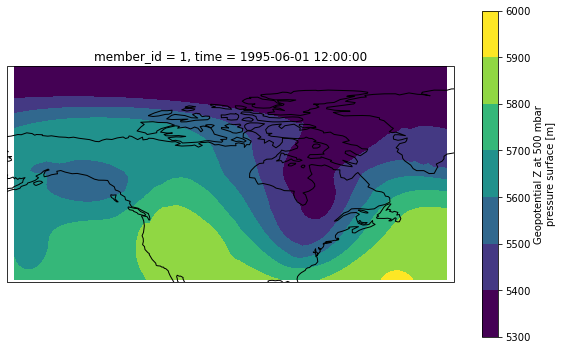

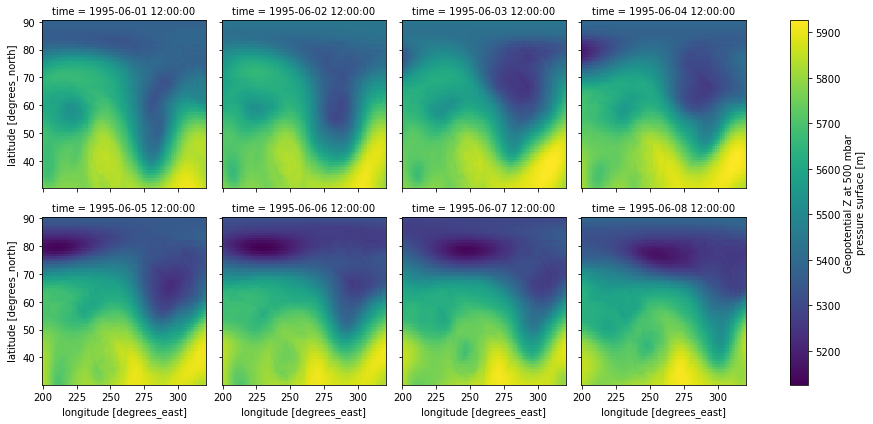

In [6]:
#visualization.
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

#single map with map
print("Single plot with underlying region map")
plt.figure(figsize = (10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_global()
ax.set_extent([-38,-162,30,90])
summer_ds[0][0].plot.contourf(ax=ax,transform=ccrs.PlateCarree())
ax.coastlines()

#multiple plots without map
print("Multiple plots at different time points")
def plot_faceted(limit,arr):
    arr[:limit].plot(x="lon", y="lat", col="time", col_wrap=4)
time_points = 8

plot_faceted(time_points,summer_ds[0])

### Perform Empirical Orthogonal Function (EOF) Analysis/PCA (in statistics)

In [7]:
import time
import numpy as np

#construct matrix for EOF /PCA
# n = no. of time points
# p= no. of features at a location (time series at a single location as a column)

X = summer_ds
time_duration = X. time.shape[0] 


F = []
time_start = time.perf_counter() #start_timer

for m in range(member_count):
    for t in range(time_duration):
        r = X[m,t].values.flatten()
        print(t,end='\r')
        F.append(r)
F = np.array(F)

time_elapsed = (time.perf_counter() - time_start) #end timer

print("time_elapsed:",time_elapsed)
print("original matrix shape:",F.shape)

time_elapsed: 983.286439014
original matrix shape: (920, 6208)


In [8]:
from numpy import savetxt
# save the matrix to csv file
savetxt('F_matrix.csv',F, delimiter=',')

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [10]:
#perform standardization

scaler = StandardScaler()# Fit on training set only.
scaler.fit_transform(F)

print("after standardized:",F.shape)

after standardized: (920, 6208)


In [11]:
#perform PCA (22 components with 96% variance)
pca = PCA(n_components= 22)
F_pca = pca.fit_transform(F)

print("PCA matrix shape :",F_pca.shape)
print(f"Total variance captured by {len(pca.components_)} components:",
      pca.explained_variance_ratio_.cumsum()[-1])

PCA matrix shape : (920, 22)
Total variance captured by 22 components: 0.95662993


In [12]:
#Reconstruct the input from EOF/PCA and calculate MSE loss
#projection
F_proj = pca.inverse_transform(F_pca)
print("Projected matrix shape:",F_proj.shape)

#reshape 
lat_dim = X.lat.shape[0]
lon_dim = X.lon.shape[0]
F_proj_reshaped = F_proj.reshape(member_count,time_duration,lat_dim,lon_dim)

#to xarray
F_proj_xr = xr.DataArray(F_proj_reshaped,dims = ["member_id","time","lat","lon"])

print("Reconstructed Xarray shape:",F_proj_xr.shape)
#plot_multiple(8,F_proj_xr.isel(member_id = 0))


Projected matrix shape: (920, 6208)
Reconstructed Xarray shape: (1, 920, 64, 97)


In [13]:
#calculating the MSE between projection and original
N = np.prod(F.shape) #mulplying all elements
#print(N)
difference = F_proj_xr - X
MSE = 1/N *(np.sqrt((difference **2).sum()).values)
print("MSE = ",MSE)

MSE =  0.007622395049077627


In [14]:
#apply K-Menas on the PCA components

#no_of clusters = 4 and 100 iteraions
KMeans_model = KMeans(
    n_clusters=4, init='random',
    n_init=10, max_iter=100, 
    tol=1e-04, random_state=0,
    verbose = 0
)

cluster_Kmeans = KMeans_model.fit(F_pca)

In [15]:
print("labels for pca components",cluster_Kmeans.labels_)

labels for pca components [0 2 2 0 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 3 3 3 3
 2 2 2 2 2 2 2 2 2 2 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 0 0 0 0 3 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 3 3 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 1 1 1 3 3 3 3 3 3 3 3 3 3 1 1 1 1 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 3 3
 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3
 3 3 3 3 3 3 0 3 3 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2
 2 2 2 2 2 2 2 2 2 2 3 3 3 2 2 2 2 2 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 3 0 0 0 0 3 3 3 3 1 1 1 3 3 3 3 3 3 0 0 0
 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 0 0 0 0 0 0 0 0 0 0 0

In [16]:
#silhoutte score 
print(f'Silhouette Score(n=4): {silhouette_score(F_pca, cluster_Kmeans.labels_)}')

Silhouette Score(n=4): 0.13585487008094788


In [17]:
#applying k means to the original data 
F_clusters = KMeans_model.fit_predict(F)

In [18]:
print(f"cluster labels for each daily pattern, {F_clusters.shape[0]} days:", F_clusters)

cluster labels for each daily pattern, 920 days: [0 2 2 0 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 3 3 3 3
 2 2 2 2 2 2 2 2 2 2 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 0 0 0 0 3 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 3 3 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 1 1 1 3 3 3 3 3 3 3 3 3 3 1 1 1 1 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 3 3
 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3
 3 3 3 3 3 3 0 3 3 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2
 2 2 2 2 2 2 2 2 2 2 3 3 3 2 2 2 2 2 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 3 0 0 0 0 3 3 3 3 1 1 1 3 3 3 3 3 3 0 0 0
 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 

In [19]:
n_elements = {0: 0,1:0,2:0,3:0}
for c in F_clusters:
    n_elements[c] = n_elements[c]+1
print(n_elements) 

{0: 157, 1: 232, 2: 269, 3: 262}


In [20]:
cluster_members = {0:[],1:[],2:[],3:[]}
for t in range(time_duration):
    cluster = F_clusters[t]
    cluster_members[cluster].append(summer_ds[0][t])

z500_summer_cluster_0 = xr.concat(cluster_members[0],dim = "time") 
z500_summer_cluster_1 = xr.concat(cluster_members[1],dim = "time") 
z500_summer_cluster_2 = xr.concat(cluster_members[2],dim = "time") 
z500_summer_cluster_3 = xr.concat(cluster_members[3],dim = "time") 

z500_summer_cluster = [z500_summer_cluster_0 ,z500_summer_cluster_1,z500_summer_cluster_2,z500_summer_cluster_3]

#### Convert each 66x 97 longitude-latitude grid to an contour plot image <br>
ref : http://xarray.pydata.org/en/stable/user-guide/plotting.html

In [21]:
import os
import shutil
import PIL
from PIL import Image
import glob
import matplotlib.pyplot as plt

In [22]:
print("no of elements in each cluster:")
for c in range(4):
    n = n_elements[c]
    print(c,n)

no of elements in each cluster:
0 157
1 232
2 269
3 262


cluster :  0 157 	
cluster :  1 232 	
cluster :  2 269 	
cluster :  3 262 	


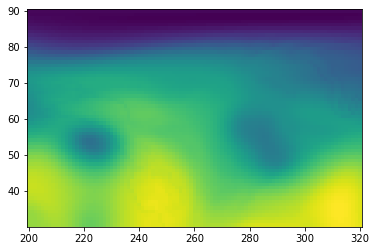

In [23]:
#convert to 432 x 288 contour plot images
#crop each image to 378x243 (remove axes labels)

left= 432-378
top=0
right =432
bottom = 243
offset = (left, top, right, bottom)


#create and store image dataset directory with 4 subdirectories for each cluster (256 images)
for i in range(4):
    if os.path.exists(f'plot_images_train//{i}'):
        shutil.rmtree(f'plot_images_train/{i}') # Removes all the subdirectories!
    os.makedirs(f'plot_images_train/{i}')
    
    if os.path.exists(f'plot_images_test//{i}'):
        shutil.rmtree(f'plot_images_test/{i}') # Removes all the subdirectories!
    os.makedirs(f'plot_images_test/{i}')    

        
#predict for year :92 days
#train = (0.7 +0.1) portion of each class for train and validation
#test = 0.2 of each class

train= 0.8
test =0.2

for c in range(4):
    n = n_elements[c]
    print("cluster : ",c,n,"\t")
    for t in range(n):
        z500_summer_cluster[c][i].plot(add_colorbar = False,add_labels = False)
        if (t < n*train):image_file= f"plot_images_train/{c}/img_0_{t}.jpg"
        else : image_file= f"plot_images_test/{c}/img_0_{t}.jpg"
        plt.savefig(image_file)
        
        #open and crop image
        im=Image.open(image_file)
        im = im.convert("RGB")
        im = im.crop(offset)
        im.save(image_file)
        print(c,"-",t,end='\r')

### Images for Prediction

In [24]:
#images for prediction

#considering year 2005
y = years_list[-1:][0]
print("year = ",y)
member = 0
summer_days =[]
Z = z500.sel(member_id = member+1,time = slice(f"{y}-06",f"{y}-08")).isel(lat = slice(128,200),lon = slice(160,257))
n_days = Z.time.shape[0] 

display(Z)

year =  2005


<xarray.DataArray 'Z500' (time: 92, lat: 64, lon: 97)>
dask.array<getitem, shape=(92, 64, 97), dtype=float32, chunksize=(92, 64, 97), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 30.63 31.57 32.51 33.46 ... 87.17 88.12 89.06 90.0
  * lon        (lon) float64 200.0 201.2 202.5 203.8 ... 316.2 317.5 318.8 320.0
    member_id  int64 1
  * time       (time) object 2005-06-01 12:00:00 ... 2005-08-31 12:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Geopotential Z at 500 mbar pressure surface
    units:         m

In [25]:
#get_cluster labels for prediction dataset

P = []
m = member

for t in range(n_days):
        r = X[m,t].values.flatten()
        print(t,end='\r')
        P.append(r)
P = np.array(P)
print("original matrix shape:",P.shape)

P_clusters = KMeans_model.fit_predict(P)

#print(f"cluster labels for each daily pattern, {P_clusters.shape[0]} days:", P_clusters)

print(" no of elements in each cluster")
p_n = {0: 0,1:0,2:0,3:0}
for c in P_clusters:
    p_n[c] = p_n[c]+1
print(p_n) 

original matrix shape: (92, 6208)
 no of elements in each cluster
{0: 21, 1: 22, 2: 29, 3: 20}


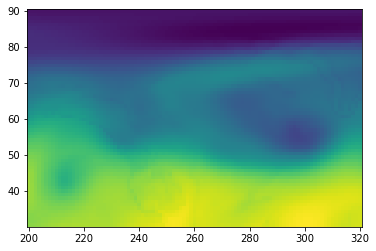

In [26]:
#save the plots

for i in range(4):
    if os.path.exists(f'plot_images_pred/{i}'):
        shutil.rmtree(f'plot_images_pred/{i}') # Removes all the subdirectories!
    os.makedirs(f'plot_images_pred/{i}')    

        
for t in range(n_days):
    cluster = P_clusters[t]
    Z[t].plot(add_colorbar = False,add_labels = False)
    image_file= f"plot_images_pred/{cluster}/img_0_{t}.jpg"  
    plt.savefig(image_file)
    
    #open and crop image
    im=Image.open(image_file)
    im = im.convert("RGB")
    im = im.crop(offset)
    im.save(image_file)
    print(f"cluster {cluster} - {t}",end='\r')

In [27]:
# save the corresponding cluster labels to csv file
savetxt('cluster_labels.csv',F_clusters, delimiter=',')
savetxt('predicted_cluster_labels.csv',P_clusters, delimiter=',')

### Compute and plot cluster centers

In [28]:
# get cluster centers

(no_days,latt,lonn) = z500_summer_cluster_0.shape

C =[]
for t in range(no_days):
        r = z500_summer_cluster_0[t].values.flatten()
        print(t,end='\r')
        C.append(r)
C = np.array(C)
#print("original matrix shape:",C.shape)
C_mean = np.mean(C,axis =0)
#print(C1[0],C1[1])
z500_summer_cluster_0_center = z500_summer_cluster_0[0].copy()
z500_summer_cluster_0_center.values = C_mean.reshape(64,97)
#display(z500_summer_cluster_0_center)

In [29]:
(no_days,latt,lonn) = z500_summer_cluster_1.shape

C =[]
for t in range(no_days):
        r = z500_summer_cluster_1[t].values.flatten()
        print(t,end='\r')
        C.append(r)
C = np.array(C)
#print("original matrix shape:",C.shape)
C_mean = np.mean(C,axis =0)
#print(C1[0],C1[1])
z500_summer_cluster_1_center = z500_summer_cluster_1[0].copy()
z500_summer_cluster_1_center.values = C_mean.reshape(64,97)
#display(z500_summer_cluster_0_center)

In [30]:
(no_days,latt,lonn) = z500_summer_cluster_2.shape

C =[]
for t in range(no_days):
        r = z500_summer_cluster_2[t].values.flatten()
        print(t,end='\r')
        C.append(r)
C = np.array(C)
#print("original matrix shape:",C.shape)
C_mean = np.mean(C,axis =0)
#print(C1[0],C1[1])
z500_summer_cluster_2_center = z500_summer_cluster_2[0].copy()
z500_summer_cluster_2_center.values = C_mean.reshape(64,97)
#display(z500_summer_cluster_0_center)

In [31]:
(no_days,latt,lonn) = z500_summer_cluster_3.shape

C =[]
for t in range(no_days):
        r = z500_summer_cluster_3[t].values.flatten()
        print(t,end='\r')
        C.append(r)
C = np.array(C)
#print("original matrix shape:",C.shape)
C_mean = np.mean(C,axis =0)
#print(C1[0],C1[1])
z500_summer_cluster_3_center = z500_summer_cluster_3[0].copy()
z500_summer_cluster_3_center.values = C_mean.reshape(64,97)
#display(z500_summer_cluster_0_center)

z500_summer cluster 1 center


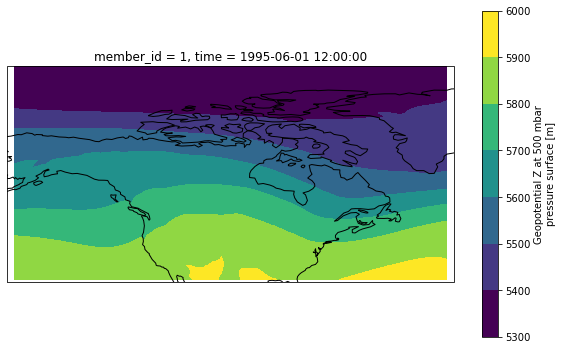

In [32]:
#plot the cluster centers
#cluster 0 center
print("z500_summer cluster 1 center")
plt.figure(figsize = (10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_global()
ax.set_extent([-38,-162,30,90])
z500_summer_cluster_0_center.plot.contourf(ax=ax,transform=ccrs.PlateCarree())
ax.coastlines()

z500_summer cluster 2 center


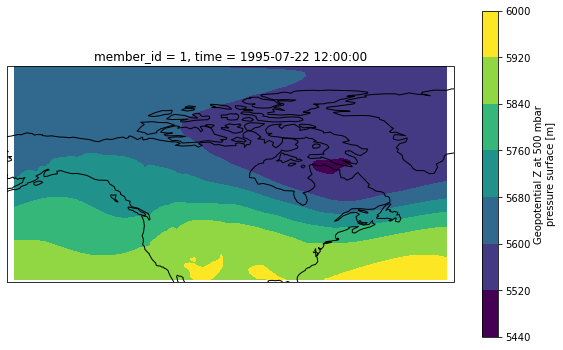

In [33]:
#cluster 1 center
print("z500_summer cluster 2 center")
plt.figure(figsize = (10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_global()
ax.set_extent([-38,-162,30,90])
z500_summer_cluster_1_center.plot.contourf(ax=ax,transform=ccrs.PlateCarree())
ax.coastlines()

z500_summer cluster 3 center


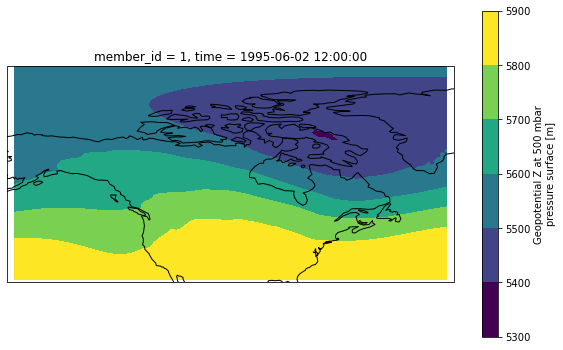

In [34]:
#cluster 2 center
print("z500_summer cluster 3 center")
plt.figure(figsize = (10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_global()
ax.set_extent([-38,-162,30,90])
z500_summer_cluster_2_center.plot.contourf(ax=ax,transform=ccrs.PlateCarree())
ax.coastlines()

z500_summer cluster 4 center


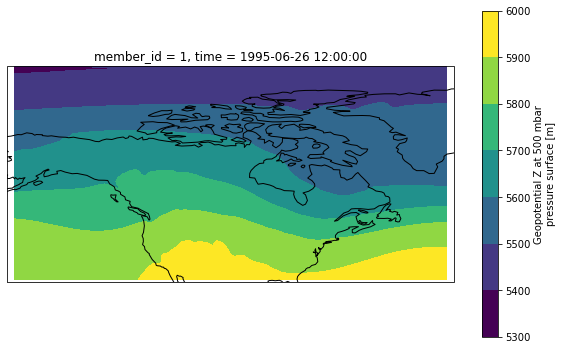

In [35]:
#cluster 3 center
print("z500_summer cluster 4 center")
plt.figure(figsize = (10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_global()
ax.set_extent([-38,-162,30,90])
z500_summer_cluster_3_center.plot.contourf(ax=ax,transform=ccrs.PlateCarree())
ax.coastlines()